In [230]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from collections import namedtuple
import numpy as np
import cupy as cp
import math

%run kernel.ipynb

4.41 μs ± 218 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.5 μs ± 64.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [231]:
config = Config()

In [438]:
%%time
images = []
image_fnames = {}

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(images)
        images.append(np.array(image).ravel())
        image_fnames[image_index] = image_fname
        
    assert image.fp is None

assert len(images) == len(image_fnames)
images = np.array(images)
print(f'Loaded {len(images)} images')

  0%|          | 0/9146 [00:00<?, ?it/s]

Loaded 9145 images
CPU times: user 523 ms, sys: 81.4 ms, total: 605 ms
Wall time: 608 ms


In [422]:
# Parameters of kernel generation. Subject to evolution
OUTLINE_WIDTH = 4/32
STRETCH_X_LEVELS = 7
STRETCH_Y_LEVELS = 7
ROTATION_LEVELS = 12
OFFSET_X_LEVELS = 5
OFFSET_Y_LEVELS = 5

assert STRETCH_X_LEVELS > 0 and STRETCH_X_LEVELS % 2
assert STRETCH_Y_LEVELS > 0 and STRETCH_Y_LEVELS % 2
assert OFFSET_X_LEVELS > 0 and OFFSET_X_LEVELS % 2
assert OFFSET_Y_LEVELS > 0 and OFFSET_Y_LEVELS % 2

In [423]:
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
offset_x_transfs = []
offset_y_transfs = []

# cover possible STRETCHES from 2x to 0.25x including 1
for i in range(STRETCH_X_LEVELS // 2):
    u = (1.0 + (i + 1) * (2 - 1) / (STRETCH_X_LEVELS // 2))
    d = (1.0 - (i + 1) * (1 - 0.25) / (STRETCH_X_LEVELS // 2))
    transf = [
        [u, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))
    transf = [
        [d, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 2x to 0.25x including 1
for i in range(STRETCH_Y_LEVELS // 2):
    u = (1.0 + (i + 1) * (2 - 1) / (STRETCH_Y_LEVELS // 2))
    d = (1.0 - (i + 1) * (1 - 0.25) / (STRETCH_Y_LEVELS // 2))
    transf = [
        [1, 0, 0],
        [0, u, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, d, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
for i in range(OFFSET_X_LEVELS // 2):
    l = 1 / ((OFFSET_X_LEVELS - 1) // 2) * (i + 1)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
offset_x_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
for i in range(OFFSET_Y_LEVELS // 2):
    u = 1 / ((OFFSET_Y_LEVELS - 1) // 2) * (i + 1)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
offset_y_transfs.append(np.array(transf))

In [424]:
transfs = []

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    transf = a @ b @ c @ d @ e
                    transfs.append(transf)

In [425]:
len(transfs)

14700

In [426]:
def draw_kernel(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image

In [480]:
kernels = []
kernel_denoms = []
half_kernel_size = (config.kernel_size - 1) / 2

# prototypes is a simple vertical bar
z = OUTLINE_WIDTH / 2
points_gold = [
    [0   - z,  0   - z,   0   + z,  0   + z ],
    [0.5 + z, -0.5 - z,  -0.5 - z,  0.5 + z ],
    [1,        1,         1,        1  ]
]

for transf in transfs:
    points = (transf @ points_gold).T
    points_x = (points[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
    points_y = (points[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
    kernel_image = draw_kernel(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    kernel_unique_counts = np.unique_counts(np.append(kernel, [0, 1]))
    assert np.array_equal(kernel_unique_counts.values, [0, 1])
    kernel_denominator = 255 * (kernel_unique_counts.counts[1] - 1)
    kernel = kernel.astype(np.float32)

    if kernel_denominator > 0:
         kernel = kernel / kernel_denominator
        
    kernels.append(kernel)
    kernel_denoms.append(kernel_denominator)

kernels = np.array(kernels)
kernel_denoms = np.array(kernel_denoms)


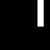
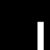
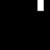
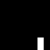
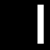
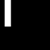
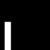
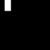
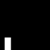
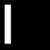
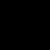
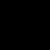
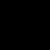
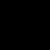
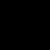
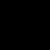
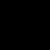
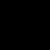
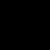
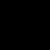
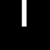
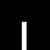
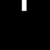
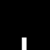
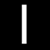
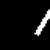
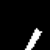
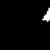
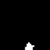
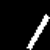
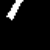
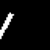
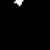
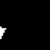
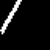
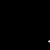
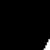
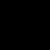
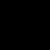
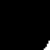
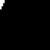
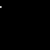
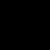
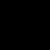
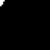
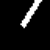
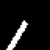
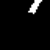
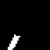
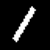
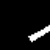
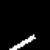
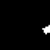
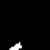
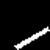
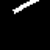
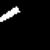
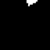
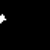
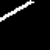
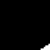
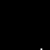
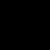
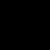
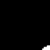
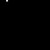
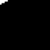
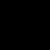
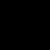
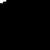
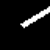
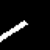
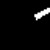
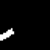
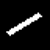
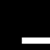
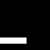
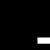
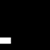
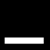
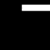
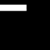
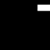
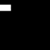
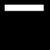
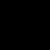
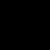
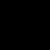
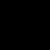
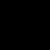
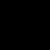
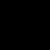
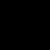
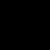
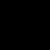
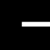
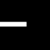
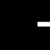
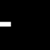
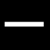
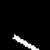
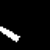
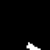
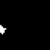
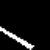
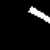
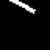
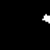
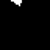
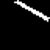
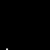
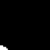
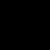
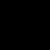
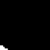
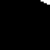
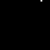
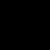
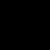
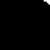
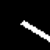
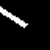
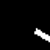
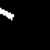
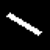
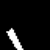
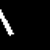
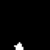
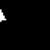
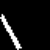
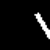
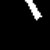
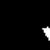
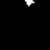
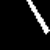
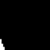
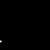
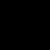
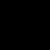
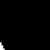
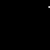
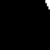
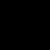
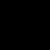
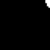
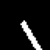
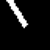
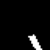
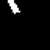
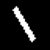
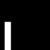
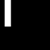
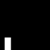
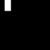
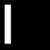
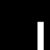
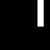
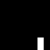
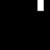
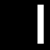
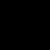
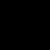
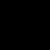
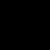
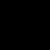
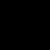
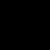
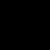
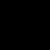
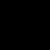
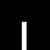
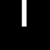
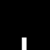
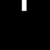
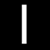
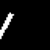
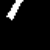
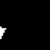
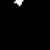
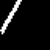
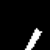
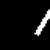
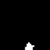
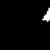
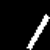
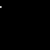
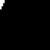
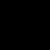
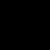
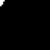
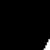
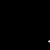
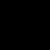
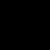
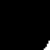
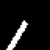
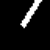
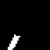
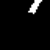
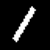
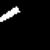
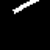
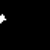
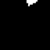
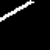
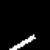
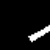
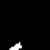
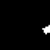
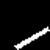
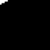
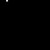
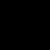
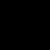
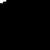
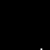
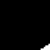
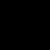
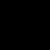
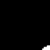
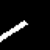
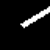
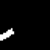
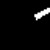
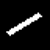
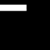
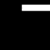
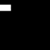
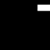
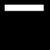
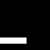
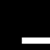
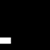
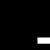
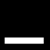
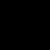
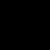
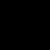
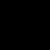
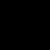
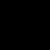
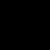
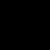
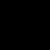
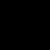
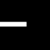
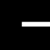
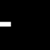
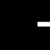
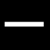
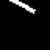
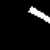
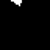
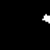
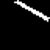
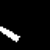

In [521]:
max_images = 256

if max_images > 0:
    kernel_images = np.copy(kernels[:max_images])
    kernel_image_denoms = kernel_denoms[:max_images]
else:
    kernel_images = np.copy(kernels)
    kernel_image_denoms = kernel_denoms

# Turn to column vector
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (256, 1)
kernel_images *= kernel_image_denoms
kernel_images *= 255

_images = []

for i in range(kernel_images.shape[0]):
    assert config.kernel_size * config.kernel_size == kernel_images[i].shape[0]
    _image = Image.frombytes('L', size=(config.kernel_size, config.kernel_size), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    
display_images_grid(_images, 16)

In [477]:
%%time
match_matrix = images @ kernels.T

CPU times: user 20 s, sys: 7.83 s, total: 27.8 s
Wall time: 2.48 s


In [478]:
match_matrix.shape

(9145, 14700)

In [479]:
match_matrix[:3]

array([[0.33823529, 0.31944444, 0.5       , ..., 0.36666667, 0.18181818,
        0.48780488],
       [0.41176471, 0.22222222, 0.21428571, ..., 0.06666667, 0.18181818,
        0.3902439 ],
       [0.38235294, 0.19444444, 0.35714286, ..., 0.26666667, 0.15151515,
        0.17073171]], shape=(3, 14700))

In [476]:
images[0] @ kernels[0].T

np.float64(0.3382352941176471)

In [1]:
if False:
    fig, ax = plt.subplots(3)
    days_count = len(train_stats)
    
    ax[0].plot(list(range(days_count)), [ts.kernel_matches for ts in train_stats])
    ax[0].set_ylabel('Kernels matches')
    
    ax[1].bar(list(range(days_count)), [ts.perceive_success_rate for ts in train_stats])
    ax[1].set_ylabel('Perf score')
    
    ax[2].bar(list(range(days_count)), [ts.kernels_match_success_rates.mean for ts in train_stats])
    ax[2].set_xlabel('Days')
    ax[2].set_ylabel('Avg kernels perf score')
    plt.show()